# Logistic model

## Imports

In [1]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress
from glob import glob

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

c:\Users\angel\Desktop\LCPA_project\mice_inspection_utils.py:1156: SyntaxWarning: invalid escape sequence '\L'
  with PdfPages(f"Inspection_Outputs\LMfits\Mouse_{mouse_num+1}_LM_Fits.pdf") as pdf:
c:\Users\angel\Desktop\LCPA_project\mice_inspection_utils.py:1238: SyntaxWarning: invalid escape sequence '\L'
  print('PDF files already exist in Inspection_Outputs\LMfits. Delete directory Inspection_Outputs\LMfits to regenerate plots.')


## Data structure

In [2]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)

,species,1,8,9,10,15,17,20,21,22,...,1001,1004,1010,1016,1022,1028,1029,1035,1039,1044
0,Prevotella sp. Smarlab 121567,0,0,0,2,10,18,21,33,3,...,220,248,252,286,346,293,277,190,222,364
1,Parabacteroides distasonis,0,0,0,2,41,145,43,58,54,...,136,157,206,133,177,105,163,147,208,222
2,Barnesiella intestinihominis,0,0,0,1,19,58,28,52,14,...,158,145,184,131,145,154,119,130,71,161
3,Barnesiella viscericola,0,1,0,1,112,195,8,15,5,...,66,85,134,96,126,121,92,71,72,147
4,Lactobacillus taiwanensis,0,422,309,0,48,15,999,156,1096,...,36,162,282,174,100,306,517,193,513,175


In [3]:
# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(10) # -> As we can see we have the count per day of the selected species in each mouse

,day,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mean,std
0,0,NaN,1.0,0.0,NaN,NaN,0.0,NaN,2.0,0.750000,0.957427
1,1,0.0,NaN,0.0,NaN,0.0,0.0,0.0,1.0,0.166667,0.408248
2,2,NaN,1.0,1.0,NaN,0.0,NaN,0.0,2.0,0.800000,0.836660
3,3,NaN,0.0,0.0,NaN,2.0,0.0,NaN,NaN,0.500000,1.000000
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.875000,2.474874
9,9,0.0,0.0,9.0,0.0,1.0,60.0,0.0,0.0,8.750000,20.940392


## Dissimilarity computation

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [4]:
mice_diss = []
oracle_file = os.path.join(os.getcwd(), "Data" ,"dissimilarities")  # Construct the path Data/dissimilarities in the current working directory (cwd)
                                                                    # "oracle" because is a source of truth or knowledge (folder that if exists, that's what we get data from)

if not os.path.exists(oracle_file): # If the folder does not exist, compute and store dissimilarities
    for mouse in range(1,2): 
        df = mi.get_dissimilarities(mouse, write = True)
        mice_diss.append(df)
    print("Database created")
else: # If the file exists, load precomputed dissimilarities
    for mouse in range(1,9): 
        folder_path = os.path.join(oracle_file, f"dissimilarity_{mouse}.csv")
        csv_files = glob(folder_path)  # Get all CSV file in folder (in general glob finds all files that match a pattern)
        df_list = [pd.read_csv(file,index_col=0)  for file in csv_files]   # Read and merge all files
        mice_diss.append(pd.concat(df_list,ignore_index=False))
        
    print("Data take from files; if you want to compute again delete folder")

Data take from files; if you want to compute again delete folder


In [5]:
# Check that it was built correctly considering for example the first mouse
mice_diss[0].head()

,1,2,3,4,5,6,7,8,9,10,...,1027,1028,1029,1030,1031,1034,1035,1036,1038,1043
Prevotella sp. Smarlab 121567,0.152198,0.171746,0.062899,0.094635,0.111559,0.100248,0.159679,0.158560,0.198151,0.141593,...,0.940133,1.0,0.930256,1.000000,1.000000,0.989131,1.000000,1.000000,1.0,1.0
Parabacteroides distasonis,0.063016,0.084766,0.051827,0.052748,0.085593,0.070336,0.085282,0.074986,0.091216,0.080886,...,0.681340,1.0,0.717952,1.000000,1.000000,0.982302,1.000000,1.000000,1.0,1.0
Barnesiella intestinihominis,0.137988,0.090815,0.087523,0.109374,0.123000,0.083900,0.144142,0.103052,0.126055,0.137472,...,0.740400,1.0,0.783781,1.000000,1.000000,0.987731,1.000000,1.000000,1.0,1.0
Barnesiella viscericola,0.160086,0.079281,0.060972,0.120502,0.157528,0.097143,0.143658,0.096437,0.122690,0.106828,...,0.654971,1.0,0.482109,1.000000,0.945956,0.986578,1.000000,0.973156,1.0,1.0
Lactobacillus taiwanensis,0.378027,0.294579,0.240163,0.315811,0.377685,0.302834,0.428027,0.476685,0.378278,0.271188,...,0.615931,1.0,0.662169,0.061591,0.009472,1.000000,0.076651,0.171177,1.0,1.0


Let's now have a graphical visualization of these dissimilarities

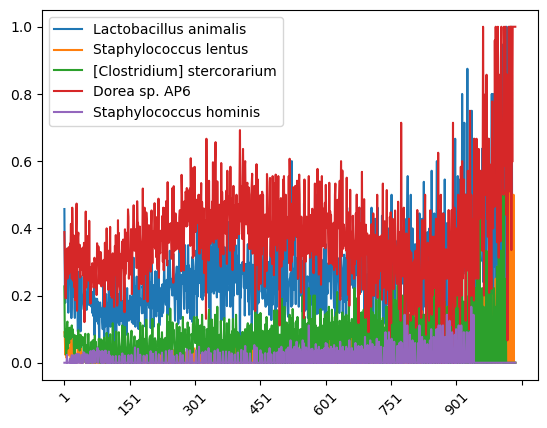

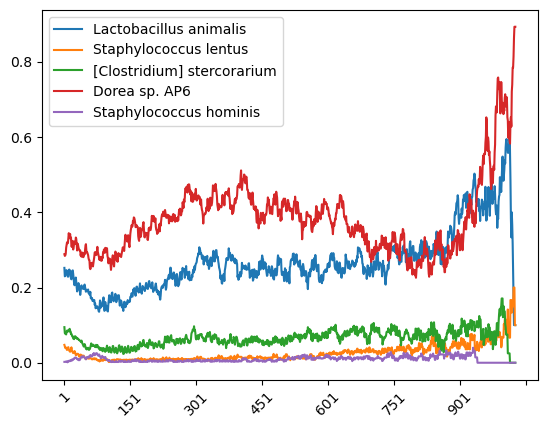

In [6]:
# For the first mice (mice_diss[0])
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

for sp in species: 
    data = mice_diss[0].loc[sp].values
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()   


In [7]:
plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

PDF files already exist in Inspection_Outputs\dissimilarityplots. Delete directory Inspection_Outputs\dissimilarityplots to regenerate plots.


## Linear fit of dissimilarities


NOTICE: To discriminate between stationary and non-stationary abundancies perform a linear fit, set a threshold and discriminate slopes above/below that threshold.

In [8]:
# Discard the initial transient (T > 10) 
for idx, mouse_df in enumerate(mice_diss): 
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

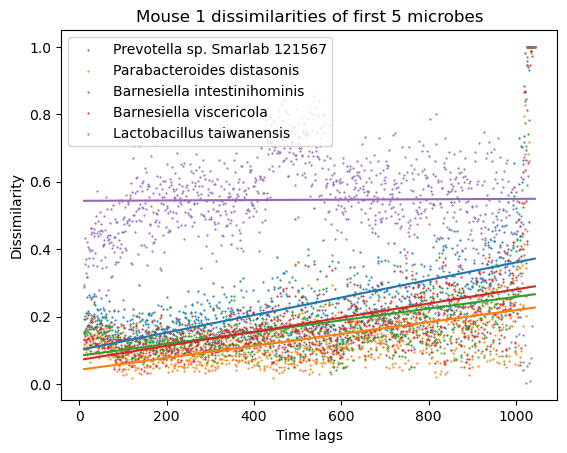

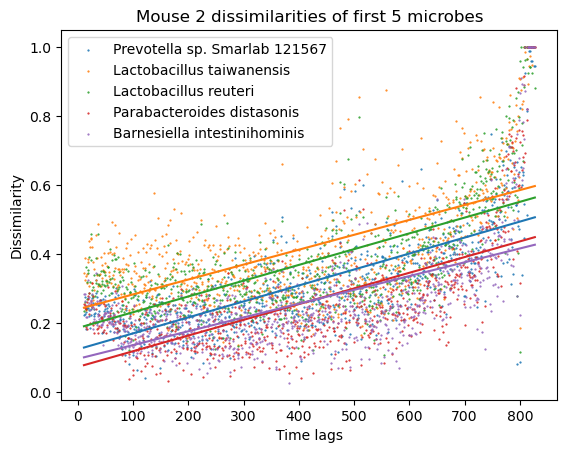

KeyboardInterrupt: 

In [9]:
# Perform a linear fit
for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    sp_m = []
    sp_q = []
    sp_pred = []
    for sp_idx in range(len(data)): 
        sp_data = np.asarray(data.iloc[sp_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, sp_data)
        pred_data = m*lags + q
        sp_m.append(m)
        sp_q.append(q)
        sp_pred.append(pred_data)
        plt.scatter(lags, sp_data, s = 0.3, label = f'{mouse_df.index[sp_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 microbes")
    plt.legend()
    plt.show()


In [ ]:
plot_dissfit_in_pdf(mice_diss, n_species_per_plot=5)

PDF files already exist in Inspection_Outputs\dissimilarityfit. Delete directory Inspection_Outputs\dissimilarityfit to regenerate plots.


## Identify the threshold for increasing curves

"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
OTU. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 

(from the article)

NOTICE: If you **do not** select only the synthetic data corresponding to the days the real data was sampled, your **threshold estimation will be biased** because the noise characteristics of your simulated data will differ from the real dataset. Here’s why:  

1. **More Frequent Sampling → Lower Noise in Dissimilarity Estimation**  
   - In the real dataset, sampling is sparse and irregular, which introduces variability in the observed slopes of $\tilde{\Phi}_i(T)$.  
   - If your simulation includes **more frequent or evenly spaced** samples than the real data, the estimated slopes will be smoother (less noise).  
   - As a result, your threshold for detecting "true" changes will be **too low**, leading to **false positives**—i.e., you might classify OTUs as "increasing" when they are actually fluctuating within noise levels.  

2. **Mismatch Between Real and Simulated Data**  
   - The original approach ensures that the **synthetic dataset mimics the structure of the real dataset**, so both are affected by similar noise due to sampling depth and frequency.  
   - By keeping all synthetic data points, you're introducing an **unrealistically high-resolution time series**, which makes the simulated slopes appear smaller than they would under real sampling conditions.  

3. **Risk of Underestimating Expected Noise**  
   - The threshold is based on the **natural variation of slopes under stationary conditions** in the SLM.  
   - If your simulated slopes are artificially stable due to oversampling, your estimated 95% quantile will be **too low**, and you may incorrectly identify more OTUs as having significant trends when, in reality, they are just affected by sparse real-world sampling.  

##### Expected Outcome:
- **If you include all synthetic data points:** The threshold will be **too strict**, and you will detect more **false trends** in the real data.  
- **If you subsample only the corresponding real sampling days:** The threshold correctly reflects the noise expected due to sampling limitations, preventing **false positives**.  

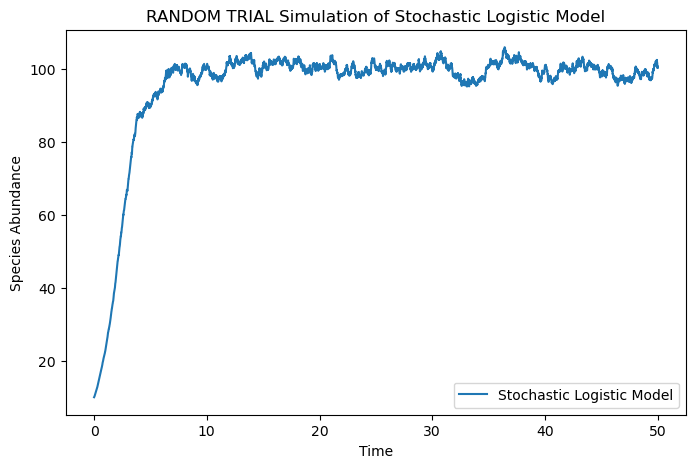

In [ ]:
# Define the function to simulate a stochastic logistic model

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]

        #--------- useful print for eventual debugging-----------------#
        growth_term = (ab/tau) * (1 - (ab / K))
        noise_term = ab * np.sqrt(sigma/tau) * np.random.normal()
        update = (growth_term + noise_term) * dt[t-1]

        #print(f"Step {t}: ab={ab}, growth={growth_term}, noise={noise_term}, update={update}")

        #--------------------------------------------------------------# 
        
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        #ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
        ab_vals[t] = max(0, ab_vals[t])
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("RANDOM TRIAL Simulation of Stochastic Logistic Model")
plt.legend()
plt.show() 

#### NOTICE: 
Our aim is to generate data from a Stochastic Logistic Model that could be consistent with the data. 
Therefore, we need to estimate what are the values of K and sigma that we expect from the data. 
To do this, we can use the theoretical relationships known for the average abundance and standard deviation of the abundance at stationarity (when sigma < 2).

"The model does not include interaction among species and therefore cannot reproduce patterns of interspecies correlation but correctly reproduces several patterns of the dynamics of a single species (15, 16).  

If $\sigma < 2$, the stationary distribution is gamma:

$$
P(\lambda; K, \sigma) = \frac{1}{\Gamma(2/\sigma - 1)} \left( \frac{2 - \sigma}{K} \right)^{\frac{2}{\sigma} -1} \lambda^{\frac{2}{\sigma} -2} e^{-\frac{2}{\sigma K} \lambda}
$$

with mean  

$$
\langle \lambda \rangle = K \frac{2 - \sigma}{\sigma}
$$  

and variance  

$$
\text{var}(\lambda) = \frac{\langle \lambda \rangle^2}{2 - \sigma}.
$$  

" (from the article). 

Hence we must: 

- Find the transient to stationarity and discard it (this can be done by fitting the data with a non-stochastic logistic model, which also gives us a hint of the parameter K); 

- Compute mean and standard deviation of the collected abundances (data); 

- Estimate the parameters from the theoretical values. 

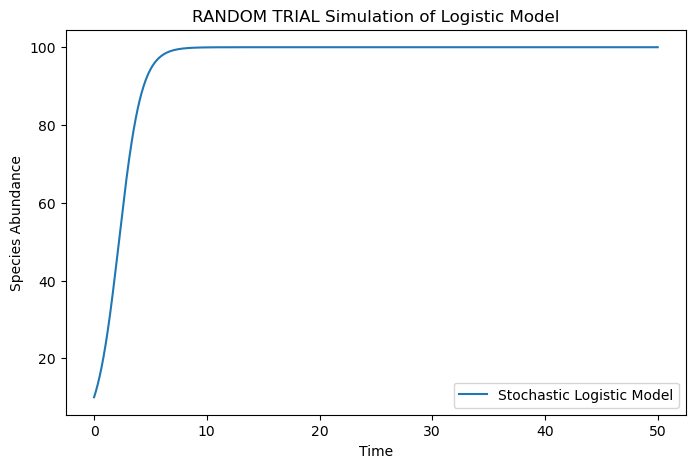

In [ ]:
# DEFINE THE LOGISTIC MODEL FUNCTION (non-stochastic)

def LM(ab0, K, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + (ab/tau)*(1 - (ab / K)) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = LM(ab0, K, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("RANDOM TRIAL Simulation of Logistic Model")
plt.legend()
plt.show()

In [ ]:
# PREPARE DATA FOR THE FIT (we want to fit abundancies, our epirical  time series)
# Let's get the data cleaning it from the columns that do not correspond to species names or abundancies
# Indeed if you print(mi.mice_df) you see there are other information not needed here

mice_ab = []
for mouse_num in range(len(mi.mice_df)): 
    columns = mi.mice_df[mouse_num].columns
    mice_ab.append(mi.mice_df[mouse_num].drop(columns = ['Unnamed: 0', 'median_counts', 'mean_counts']))
#print(mice_ab[0])

#### TRIAL FOR FIRST MOUSE

Estimated K: 444.15999693946776
Estimated tau: 2.831253090545916


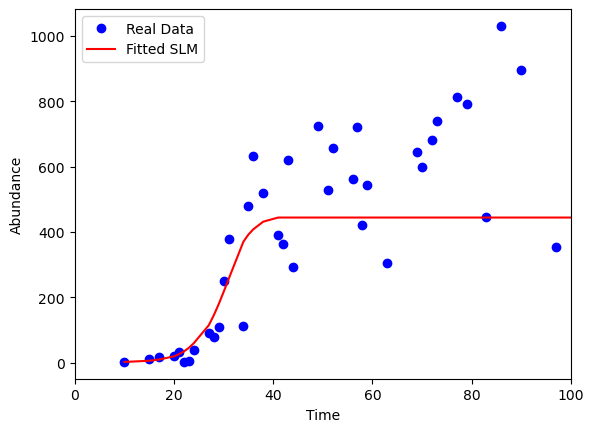

In [ ]:
# FIT TO GET THE VALUE OF K --> TRIAL FOR THE FIRST SPECIE

# Load the first mouse's data
df = mice_ab[0]
species = df['species']
ts_data = df.iloc[0, 1:].to_numpy()
nonzero = np.nonzero(ts_data)[0]
start_idx = nonzero[0] + 1  # Adjust for skipped species column if needed
time_series = df.iloc[0, start_idx:].to_numpy()  # Extract the first species' time series
days = np.asarray(df.columns[start_idx:], dtype=int)  # Get measurement days
dt = np.diff(days)  # Compute time intervals

# Objective function for optimization
def objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(
        ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt
    )
    
    if np.isnan(simulated_data).any():  # Check for NaN values
        return np.inf  # Return a large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

# Define parameter bounds
bounds_K = (1, 1e3)  # Carrying capacity
bounds_tau = (0.5, 5.5)  # Timescale parameter
bounds = [bounds_K, bounds_tau]

# Step 1: Use Differential Evolution for Global Search
result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')

K_opt, tau_opt = result.x
print(f"Estimated K: {K_opt}")
print(f"Estimated tau: {tau_opt}")

""" --> useless 'cause we get the same
# Step 2: Use L-BFGS-B for Local Refinement
result_refined = opt.minimize(objective, [K_opt, tau_opt], args=(time_series, dt),
                              method='L-BFGS-B', bounds=bounds)

K_opt, tau_opt = result_refined.x
print("\nAfter L-BFGS-B Refinement:")
print(f"Refined K: {K_opt}")
print(f"Refined tau: {tau_opt}")

"""
# Simulate data using refined parameters
fitted_data = LM(
    ab0=time_series[0], K=K_opt, tau=tau_opt, steps=len(time_series)-1, dt=dt
)

# Plot real vs fitted data
plt.plot(days, time_series, 'bo', label="Real Data")
plt.plot(days, fitted_data, 'r-', label="Fitted SLM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.xlim(0,100) 
plt.legend()
plt.show()

In [ ]:
# GET RID OF TRANSIENT -> TRIAL FIRST SPECIE

def find_transient_end(time_series, window_size=10, threshold=0.01):
    variances = [np.var(time_series[i-window_size:i]) for i in range(window_size, len(time_series))]
    changes = np.abs(np.diff(variances))  # Change in variance, if small we reached stationarity
    
    for idx, change in enumerate(changes):
        if change < threshold:
            return idx + window_size  # Adjust index due to slicing

    return 0  # If no stable region is found, return 0 (keep all data)

# Discard the initial transient 
# Calculate the time required to reach a certain percentage of K 

transient_end_idx = find_transient_end(fitted_data)  

# Discard the transient phase from the time series

time_series_red = time_series[transient_end_idx:]
days_red=days[transient_end_idx:]


In [ ]:
# ESTIMATE THE VALUES OF K AND SIGMA FROM THEORY -- > TRIAL FIRST SPECIE
var=np.var(time_series_red)
mean=np.mean(time_series_red)

sigma_th=2*var/(mean**2+var)
K_th=mean*2/(2-sigma_th)

print("Theoretical K:", K_th)
print("Theoretical sigma:", sigma_th)

Theoretical K: 522.7782979601894
Theoretical sigma: 0.32433748030850906


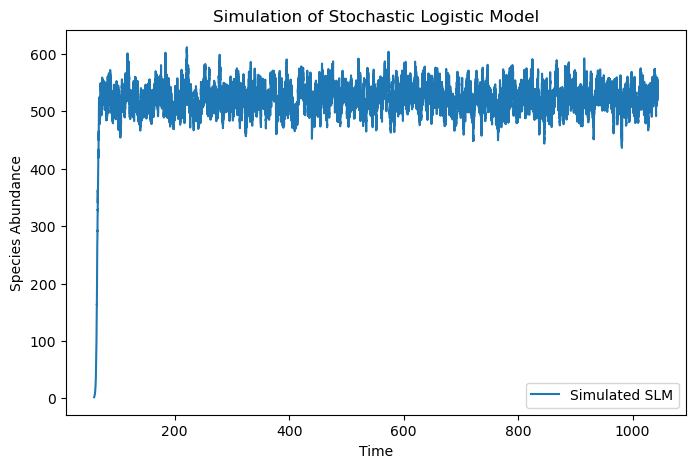

In [ ]:
# GENERATE SYNTHETIC DATA USING SLM --> TRIAL FIRST SPECIE

# Parameters
ab0 = df.iloc[0,df.iloc[0].to_numpy().nonzero()[0][1]]   # Initial population size --> discarding the first initial points being zero, else we get all zero
K = K_th    # Carrying capacity
sigma = sigma_th  # Noise intensity
tau = 1  # Characteristic time scale --> WE COULD ALSO USE TAU DEFINED ABOVE
# time = np.asarray(df_red.columns, dtype = int)
# dt = [(time[i+1] - time[i]) for i in range(len(time) - 1 )] # Time step
time = np.arange(min(days_red), max(days_red), 0.01)
steps = len(time) - 1
dt = steps*[0.01]

# Run simulation
sim_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time, sim_vals, label="Simulated SLM")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show() 


To compute the threshold for this first mice, we have to generate this stationarity distribution for all species 

### FOR ALL MICE AND SPECIES

In [ ]:
def lm_objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt)
    
    if np.isnan(simulated_data).any():  
        return np.inf  # Large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

def find_transient_end(time_series, window_size=10, threshold=0.01):
    variances = [np.var(time_series[i-window_size:i]) for i in range(window_size, len(time_series))]
    changes = np.abs(np.diff(variances))  # Change in variance, if small we reached stationarity
    
    for idx, change in enumerate(changes):
        if change < threshold:
            return idx + window_size  # Adjust index due to slicing

    return 0  # If no stable region is found, return 0 (keep all data)

# Define parameter bounds
bounds_K = (1, 1e3)  
bounds_tau = (0.5, 5.5)  
bounds = [bounds_K, bounds_tau]

# Store  parameters for all mice and species

In [ ]:
params_to_pdf(mi, mice_ab, objective, bounds, LM, find_transient_end, file_path="parameters_data.npz", force_recompute=False)

Parameters loaded from file


array([[[5.22778298e+02, 2.83125096e+00, 3.24337480e-01],
        [2.41492764e+02, 2.41363767e+00, 1.94562883e-01],
        [1.74372942e+02, 1.85780046e+00, 2.91019256e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[5.45685693e+02, 5.50000000e+00, 3.54364039e-01],
        [4.81500742e+02, 2.11706843e+00, 6.37592961e-01],
        [3.09206759e+02, 4.81949185e+00, 4.99385974e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[4.39654829e+02, 4.17897469e+00, 3.30508498e-01],
        [4.03577940e+02, 1.75138216e+00, 7.21436558e-01],
        [7.10815305e+02, 4.12157407e+00, 1.10525281e+00],
        ...,
        [           nan, 3.56787688e+00, 2.00000000e+00],
        [           nan, 3.58

In [ ]:
##### VERY LONG TO COMPUTE !!! #####
file_path = "parameters_data.npz"
    
if not os.path.exists(file_path):  
    num_mice=len(mi.mice_df)
    num_species=max(len(df['species']) for df in mice_ab)
    parameters = np.zeros((num_mice, num_species, 3))

    for mouse_num in range(len(mi.mice_df)):  # Loop over all mice
        df = mice_ab[mouse_num]
        species = df['species']

        with PdfPages(f"Mouse_{mouse_num+1}_LM_Fits.pdf") as pdf:
            fig, ax = plt.subplots(figsize=(8, 6))  # Create a single figure
            plot_count = 0  # Counter to track species in a single figure
        
            for idx, sp in enumerate(species):      # Loop over all species in the mouse
                ts_data = df.iloc[idx, 1:].to_numpy()
                nonzero = np.nonzero(ts_data)[0]

                if nonzero.size > 0:  # Ensure there is at least one nonzero value
                    start_idx = nonzero[0] + 1  # Adjust for skipped species column
                    time_series = df.iloc[idx, start_idx:].to_numpy()  
                    days = np.asarray(df.columns[start_idx:], dtype=int)  
                    dt = np.diff(days)  
                    result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')
                    K_opt, tau_opt = result.x

                    # Simulate data using optimized parameters
                    fitted_data = LM(time_series[0], K_opt, tau_opt, len(time_series)-1, dt)

                    # Identify transient phase: Discard data until it reaches carrying capacity
                    transient_end_idx = find_transient_end(fitted_data)
                
                    # Keep only post-transient data
                    time_series_red = time_series[transient_end_idx:]

                    # Compute theoretical estimates of K and sigma
                    var = np.var(time_series_red)
                    mean = np.mean(time_series_red)
                    sigma_th = 2 * var / (mean**2 + var)
                    K_th = mean * 2 / (2 - sigma_th)

                    # Store computed values
                    parameters[mouse_num, idx, 0] = K_th
                    parameters[mouse_num, idx, 1] = tau_opt
                    parameters[mouse_num, idx, 2] = sigma_th

                    # Plot current species in the same figure
                    ax.scatter(days, time_series, marker='o', s=30, label=f"Species {sp} (Real)")
                    ax.plot(days, fitted_data, linestyle='--', label=f"Species {sp} (Fitted)")

                    plot_count += 1
                    if plot_count == 5:
                        ax.set_xlabel("Time")
                        ax.set_ylabel("Abundance")
                        ax.set_xlim(0, 100)
                        ax.legend()
                        ax.set_title(f"Mouse {mouse_num+1} - Species Fit")
                        
                        pdf.savefig(fig)  # Save current figure to PDF
                        plt.close(fig)  # Close the current figure
                        
                        fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure
                        plot_count = 0  # Reset counter

                else:  # If species is always zero
                    parameters[mouse_num, idx, :] = [0, 0, 0]

            # Save any remaining plots (if less than 5 species were plotted in the last figure)
            if plot_count > 0:
                ax.set_xlabel("Time")
                ax.set_ylabel("Abundance")
                ax.set_xlim(0, 100)
                ax.legend()
                ax.set_title(f"Mouse {mouse_num+1} - Species Fit")
                
                pdf.savefig(fig)  
                plt.close(fig)  

        print(f"Saved PDF with LM fit for Mouse {mouse_num+1}")

    # Display results
    print("Shape of parameters array:", parameters.shape)  # Should be (num_mice, num_species, 3)
    np.savez("parameters_data.npz", parameters=parameters)
    print("Parameters saved in parameters_data.npz")

else:
    loaded_data = np.load("parameters_data.npz")
    parameters = loaded_data['parameters']  # Retrieve the 'parameters' array
    print("Parameter loaded form file")



Parameter loaded form file


In [ ]:
# DISCLAIMER !! QUESTA FUNCTION WORKS BUUUUUT MUST CHECK WHAT IT RETURNS AND LET IT GIVE BACK K_VALS AND SO ON
# Otherwise then it does not work when using those params in threshold
K_df, tau_df, sigma_df = params_to_csv(mi, mice_ab, objective, bounds, LM, find_transient_end, force_recompute=False)

Loaded K, sigma, tau dataframes from csv files


In [ ]:
##### VERY LONG TO COMPUTE !!! ##### --> SUBSTITUTED WITH THE ABOVE!
file_path = "K_values.csv"
    
if not os.path.exists(file_path):  

    # Initialize dictionaries to store parameters per mouse
    K_dict = {}
    tau_dict = {}
    sigma_dict = {}

    num_mice = len(mi.mice_df)
    all_species = sorted(set(sp for df in mice_ab for sp in df['species']))  # Get all unique species

    # Loop over all mice
    for mouse_num in range(len(mi.mice_df)):  
        df = mice_ab[mouse_num]
        species = df['species']

        # Initialize dictionaries for this mouse (default to NaN)
        K_dict[f"Mouse {mouse_num+1}"] = {sp: np.nan for sp in all_species}
        tau_dict[f"Mouse {mouse_num+1}"] = {sp: np.nan for sp in all_species}
        sigma_dict[f"Mouse {mouse_num+1}"] = {sp: np.nan for sp in all_species}

        with PdfPages(f"Mouse_{mouse_num+1}_LM_Fits.pdf") as pdf:
            fig, ax = plt.subplots(figsize=(8, 6))  # Create a single figure
            plot_count = 0  # Counter to track species in a single figure

            for idx, sp in enumerate(species):  # Loop over all species in the mouse
                ts_data = df.iloc[idx, 1:].to_numpy()
                nonzero = np.nonzero(ts_data)[0]

                if nonzero.size > 0:  # Ensure there is at least one nonzero value
                    start_idx = nonzero[0] + 1  # Adjust for skipped species column
                    time_series = df.iloc[idx, start_idx:].to_numpy()
                    days = np.asarray(df.columns[start_idx:], dtype=int)
                    dt = np.diff(days)
                    result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')
                    K_opt, tau_opt = result.x

                    # Simulate data using optimized parameters
                    fitted_data = LM(time_series[0], K_opt, tau_opt, len(time_series)-1, dt)

                    # Identify transient phase: Discard data until it reaches carrying capacity
                    transient_end_idx = find_transient_end(fitted_data)

                    # Keep only post-transient data
                    time_series_red = time_series[transient_end_idx:]

                    # Compute theoretical estimates of K and sigma
                    var = np.var(time_series_red)
                    mean = np.mean(time_series_red)
                    sigma_th = 2 * var / (mean**2 + var)
                    K_th = mean * 2 / (2 - sigma_th)

                    # Store computed values in dictionaries
                    K_dict[f"Mouse {mouse_num+1}"][sp] = K_th
                    tau_dict[f"Mouse {mouse_num+1}"][sp] = tau_opt
                    sigma_dict[f"Mouse {mouse_num+1}"][sp] = sigma_th

                    # Plot current species in the same figure
                    ax.scatter(days, time_series, marker='o', s=30, label=f"Species {sp} (Real)")
                    ax.plot(days, fitted_data, linestyle='--', label=f"Species {sp} (Fitted)")

                    plot_count += 1
                    if plot_count == 5:
                        ax.set_xlabel("Time")
                        ax.set_ylabel("Abundance")
                        ax.set_xlim(0, 100)
                        ax.legend()
                        ax.set_title(f"Mouse {mouse_num+1} - Species Fit")
                        
                        pdf.savefig(fig)  # Save current figure to PDF
                        plt.close(fig)  # Close the current figure
                        
                        fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure
                        plot_count = 0  # Reset counter

                else:  # If species is always zero, store 0 values
                    K_dict[f"Mouse {mouse_num+1}"][sp] = 0
                    tau_dict[f"Mouse {mouse_num+1}"][sp] = 0
                    sigma_dict[f"Mouse {mouse_num+1}"][sp] = 0
        print(f"Saved PDF with LM fit for Mouse {mouse_num+1}")

    # Convert dictionaries to DataFrames
    K_df = pd.DataFrame(K_dict)
    tau_df = pd.DataFrame(tau_dict)
    sigma_df = pd.DataFrame(sigma_dict)

    # Save DataFrames to CSV files
    K_df.to_csv("K_values.csv")
    tau_df.to_csv("tau_values.csv")
    sigma_df.to_csv("sigma_values.csv")
    print("Parameters dataframes saved in csv files")

    # Display DataFrames
    print("K Values DataFrame:")
    print(K_df)

    print("Tau Values DataFrame:")
    print(tau_df)

    print("Sigma Values DataFrame:")
    print(sigma_df)

else:
    K_df=pd.read_csv("K_values.csv")
    tau_df=pd.read_csv("tau_values.csv")
    sigma_df=pd.read_csv("sigma_values.csv")
    print('Loaded K, sigma, tau dataframes from csv files')

Loaded K, sigma, tau dataframes from csv files


In [ ]:
# DEFINE THE FUNCTIONS TO COMPUTE DISSIMILARITY AND THRESHOLD --> It's the same function that is in inspection.utils (maybe we can find a way to generalize)

def dissimilarity(simulated_series):
        dissimilarity_data=[]
        days=np.arange(0,len(simulated_series),1)
        valid_day_pairs = {T: {day for day in days if (day + T) in days} for T in range(1, len(simulated_series) + 1)}

# For each species, compute dissimilarities by time lag
        for T in range(1, len(simulated_series) + 1):
                total_diss = 0
                count = 0
                for day in valid_day_pairs[T]:
                    diss_t = ((simulated_series[day] - simulated_series[day + T]) / 
                            max(1, (simulated_series[day] + simulated_series[day + T])))**2
                    total_diss += diss_t
                    count += 1

                # Only store dissimilarities for time lags with valid days
                if count > 0:
                    dissimilarity_data.append(total_diss / count)
                    
        return dissimilarity_data 
'''
def threshold(start, k_vals, sigma_vals, df):
    """
    NOTICE: 
    1. Extract the real measurement days before filtering out zero counts.
    2. Use those extracted measurement days to subsample the simulated data.
    3. Compute dissimilarity only on the subsampled simulated data.
    """
    slopes, sim_serie_diss = [], []
    
    for i in range(len(k_vals)):    # remember: there's a k for each specie

        # Extract real measurement days (before filtering out zeros!)
        measurement_days = np.asarray(df.columns[start[i]:], dtype = int)
        start_day=int(df.columns[start[i]])
    
        # Simulate data with theorical K and sigma  
        # time_steps = np.diff(measurement_days) / 10
        time_steps = 0.1 

        simulated_series = simulate_SLM(ab0=start[i],  
                                        K=(k_vals.iloc[i].values),
                                        sigma=(sigma_vals.iloc[i].values), 
                                        tau=1.0, # THIS COULD MAYBE BE CHANGED WITH TAU_OPT
                                        steps= len(measurement_days) * 10,  # Total steps 
                                        dt = np.repeat(time_steps,10))
        
        # Select only the simulated values corresponding to the real measurement days
        nsteps_per_day = int(1/dt) # 100
        indexes_to_extract = measurement_days * nsteps_per_day
        indexes_to_extract = (measurement_days - start_day) * nsteps_per_day

        simulated_series_sampled = simulated_series[indexes_to_extract]

        time_vals = np.linspace(0, steps * dt, steps + 1)
        plt.plot(time_vals, simulated_series, label="Stochastic Logistic Model")
        plt.xlabel("Time")
        plt.ylabel("Species Abundance")
        plt.scatter(measurement_days, simulated_series_sampled, color = "red", s= 20, label= "extracted days")
        plt.legend()
        plt.show() 

        
        # We compute the dissimilarity of simulated data; so we can take the 5% of percentile
        simulated_series_diss = dissimilarity(simulated_series_sampled) 
        sim_serie_diss.append(simulated_series_diss)
        
        if i==0:
            plt.plot(np.arange(0,len(simulated_series_diss),1), simulated_series_diss)
            plt.title("Simulated series dissimilarity")
            plt.show()

        slope, _, _, _, _ = np.abs(linregress(np.arange(len(simulated_series_diss)), simulated_series_diss))
        slopes.append(slope)
    
    threshold_value = np.percentile(slopes, 95) 
    return threshold_value'
    ''
    '''

def threshold(start, K_df, sigma_df, df, mouse_num):
    """
    Compute the threshold based on simulated species dissimilarity.
    
    Args:
    - start: Starting abundance index for each species.
    - K_df: DataFrame of carrying capacities (species x mice).
    - sigma_df: DataFrame of sigma values (species x mice).
    - df: Abundance DataFrame (species x time points).
    - mouse_num: Integer indicating which mouse's data to process.
    
    Returns:
    - threshold_value: 95th percentile of dissimilarity slopes.
    """
    slopes, sim_serie_diss = [], []

    species_list = df.index  # Get species names

    # for species in species_list: 
    for spidx, species in enumerate(species_list): 
        measurement_days = np.asarray(df.columns[start[spidx]:], dtype=int)
        if spidx == 0: 
             print("start", start)
             print("start shape", np.shape(start))
             print("start[spidx]")
             print("measurement days",measurement_days)
        # measurement_days = np.asarray(df.columns[start[specie]:], dtype=int)
        start_day = int(df.columns[start[spidx]])

        # Extract K and sigma values for this species & mouse
        K_val = K_df.loc[species, f"Mouse {mouse_num+1}"]
        sigma_val = sigma_df.loc[species, f"Mouse {mouse_num+1}"]

        # Simulate data with theoretical K and sigma
        time_steps = 0.1
        steps = len(measurement_days) * 10 *5  # Total simulation steps
        dt = np.full(steps, time_steps)  # Constant time step

        """
        initial_value = df.iloc[spidx, start[spidx]]
        simulated_series = simulate_SLM(
        ab0=initial_value,
        K=K_val,
        sigma=sigma_val,
        tau=1.0,
        steps=steps,
        dt=dt
        )
        """
        
        simulated_series = simulate_SLM(
            ab0=start[spidx],  
            K=K_val,
            sigma=sigma_val,
            tau=1.0,  
            steps=steps,
            dt=dt
        )
        
        # Extract simulated values for real measurement days
        nsteps_per_day = int(1 / time_steps)
        indexes_to_extract = np.clip((measurement_days - start_day) * nsteps_per_day, 0, len(simulated_series) - 1)
        simulated_series_sampled = simulated_series[indexes_to_extract]

        # Plot simulation results
        if species == species_list[0]:
            time_vals = np.linspace(start_day, steps * time_steps, steps + 1)
            plt.plot(time_vals, simulated_series, label="Stochastic Logistic Model")
            plt.scatter(measurement_days, simulated_series_sampled, color="red", s=20, label="Extracted days")
            plt.xlabel("Time")
            plt.ylabel("Species Abundance")
            plt.title(f"Simulated SLM sampled as {species} in mouse {mouse_num+1}")
            plt.legend()
            plt.show()

        # Compute dissimilarity and extract threshold
        simulated_series_diss = dissimilarity(simulated_series_sampled)
        sim_serie_diss.append(simulated_series_diss)

        if species == species_list[0]:  # Plot only for the first species
            plt.scatter(np.arange(len(simulated_series_diss)), simulated_series_diss)
            plt.title("Simulated series dissimilarity")
            plt.show()

        slope, _, _, _, _ = linregress(np.arange(len(simulated_series_diss)), simulated_series_diss)
        slopes.append(abs(slope))  # Ensure positive slopes

    #threshold_value = np.percentile(slopes, 95)  # 95th percentile as threshold
    threshold_value = np.percentile(slopes, 85)  # 95th percentile as threshold
    return threshold_value


## Stationarity: 

Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  

first nonzero_idx [ 5  4  5  4 10  4  4  4  2  5  0  3  1 14  4  4  6  4  5  4 12  4  1  4
  3  4  6  6  6  4  3  5  6  4  6  3  6  3  5  6  3  4  6  4  4  1  7  3
 11  6  4 16 16  6 10  6  3  6 16  7 46  5  3 15  4  6  1  1  0  3  1  9
  7  4  4  4  4  5  3  5  6  4  3  5  4  5  5  4  5  3  4  4  4  4  5 20
  4  6  4  3  1  4  1 35  3  4]
Mouse 1: First nonzero species at index [ 5  4  5  4 10  4  4  4  2  5  0  3  1 14  4  4  6  4  5  4 12  4  1  4
  3  4  6  6  6  4  3  5  6  4  6  3  6  3  5  6  3  4  6  4  4  1  7  3
 11  6  4 16 16  6 10  6  3  6 16  7 46  5  3 15  4  6  1  1  0  3  1  9
  7  4  4  4  4  5  3  5  6  4  3  5  4  5  5  4  5  3  4  4  4  4  5 20
  4  6  4  3  1  4  1 35  3  4]
start [ 5  4  5  4 10  4  4  4  2  5  0  3  1 14  4  4  6  4  5  4 12  4  1  4
  3  4  6  6  6  4  3  5  6  4  6  3  6  3  5  6  3  4  6  4  4  1  7  3
 11  6  4 16 16  6 10  6  3  6 16  7 46  5  3 15  4  6  1  1  0  3  1  9
  7  4  4  4  4  5  3  5  6  4  3  5  4  5  5  4  5  3  4  4  4  4  5

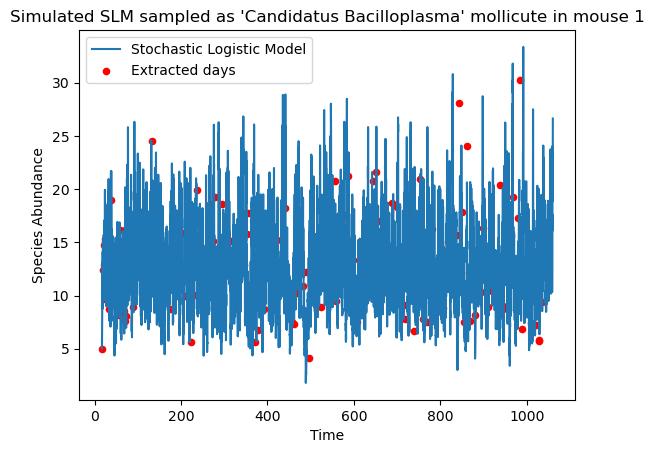

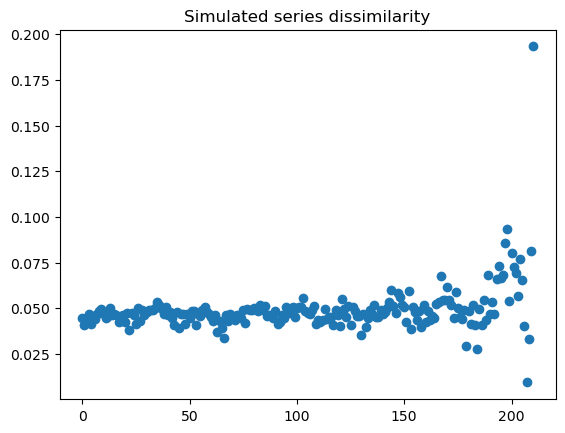

Processing Mouse 1, obtained threshold: 0.0005312493670094611
Trends for Mouse 1 appended to dataframe
first nonzero_idx [  9   7  10   7  12   7   7  10   0  10   0   7   2  10   7  10  10   2
  10   7   7   7   6   7   7   7   2  10  11   2   7  11  10   7  10   2
  10   2   7   7   0   7  10   1   8   7   9   6  20  15   7  24  21  10
   2  12   7   8  20  10 106  10   7  15   7  14  12   0   0   0   3   8
  10   8  10   0   7   9   7   9  10   8   9   9  10  10  19  10  10   0
   2   7   7   7   7  15   9   8   7   9   7   7  13  80   7   1]
Mouse 2: First nonzero species at index [  9   7  10   7  12   7   7  10   0  10   0   7   2  10   7  10  10   2
  10   7   7   7   6   7   7   7   2  10  11   2   7  11  10   7  10   2
  10   2   7   7   0   7  10   1   8   7   9   6  20  15   7  24  21  10
   2  12   7   8  20  10 106  10   7  15   7  14  12   0   0   0   3   8
  10   8  10   0   7   9   7   9  10   8   9   9  10  10  19  10  10   0
   2   7   7   7   7  15   9   8   7   9   

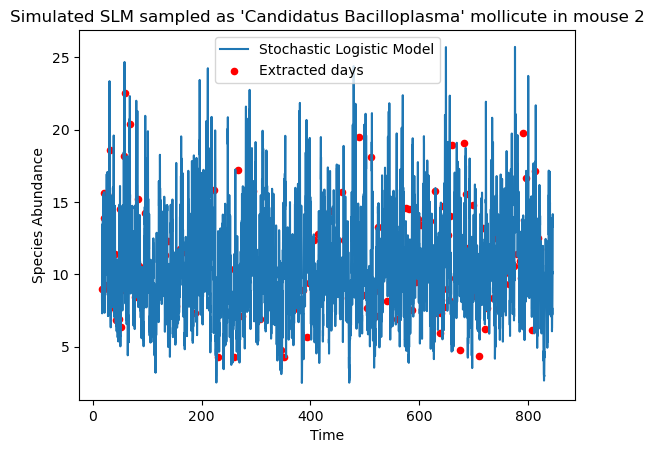

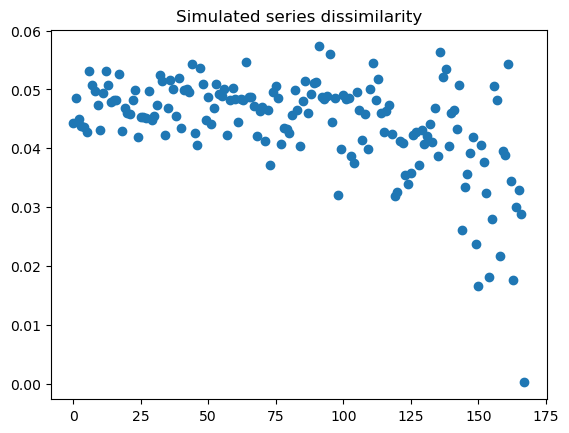

Processing Mouse 2, obtained threshold: 0.0007207472104484118
Trends for Mouse 2 appended to dataframe
first nonzero_idx [ 10   8   5   5  13   5   7  11   4   0   3   8   2  11   5   5  11   5
   9   5   5   5   4   5   5   5   5   7   7   5   5  14  11  12   5   4
  12   5  10   5   5   7  11   5   5   9   8   4   0  11   5  15  10   5
   5  11   5   9   5  11 105   3   5  12   5   2   5   0   2   4   2   4
  10   5   5   5   5  10   5  12  12   2   0   4  10   5  10   8   5   2
   4   5   5   8   5   5   5   5   7   5   5   4   4   5   5   5]
Mouse 3: First nonzero species at index [ 10   8   5   5  13   5   7  11   4   0   3   8   2  11   5   5  11   5
   9   5   5   5   4   5   5   5   5   7   7   5   5  14  11  12   5   4
  12   5  10   5   5   7  11   5   5   9   8   4   0  11   5  15  10   5
   5  11   5   9   5  11 105   3   5  12   5   2   5   0   2   4   2   4
  10   5   5   5   5  10   5  12  12   2   0   4  10   5  10   8   5   2
   4   5   5   8   5   5   5   5   7   5   

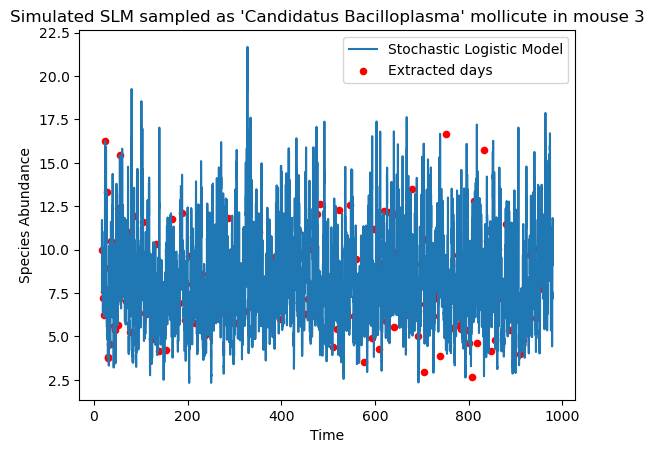

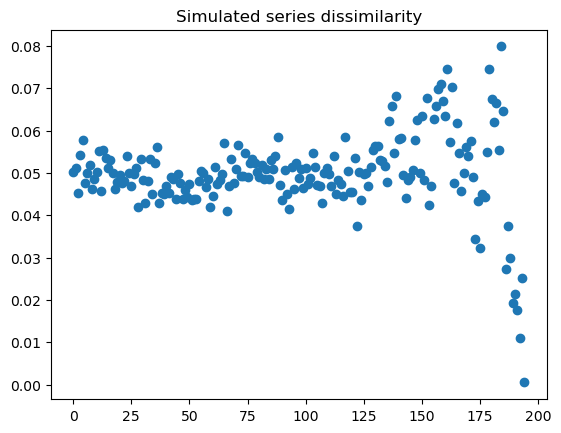

Processing Mouse 3, obtained threshold: 0.0006642792272442202
Trends for Mouse 3 appended to dataframe
first nonzero_idx [  5   3   2   2  16   4   3   2   1   6   2   2   2  10   6   4   2   2
   6   2   8   6   7   2   2   3   5   4   5   4   2   2   3   3   6   4
   6   3   4   4   4   2   6   4   5   5   6   2  22   6   3  13  18   2
  20   6   4   3  14   6 101   2   6   3   4   2   1   0   0   1   0   3
   5   2   2   4   3   5   2   5   5   2   2   2   2   2   5   4   2   2
   2   2   2   4   4  11   5   4   2   3   2   2   6  75   4   6]
Mouse 4: First nonzero species at index [  5   3   2   2  16   4   3   2   1   6   2   2   2  10   6   4   2   2
   6   2   8   6   7   2   2   3   5   4   5   4   2   2   3   3   6   4
   6   3   4   4   4   2   6   4   5   5   6   2  22   6   3  13  18   2
  20   6   4   3  14   6 101   2   6   3   4   2   1   0   0   1   0   3
   5   2   2   4   3   5   2   5   5   2   2   2   2   2   5   4   2   2
   2   2   2   4   4  11   5   4   2   3   

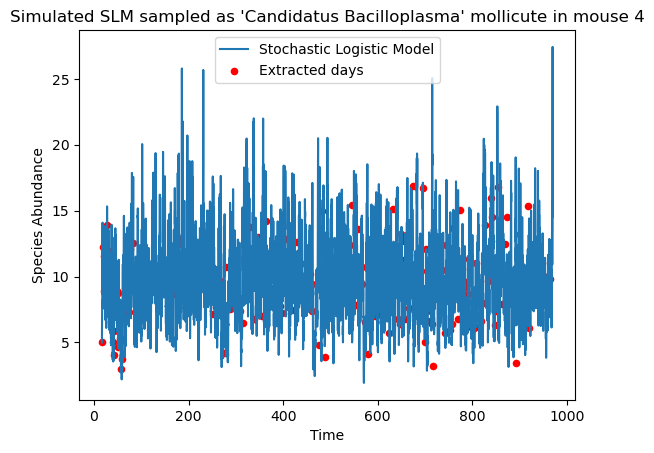

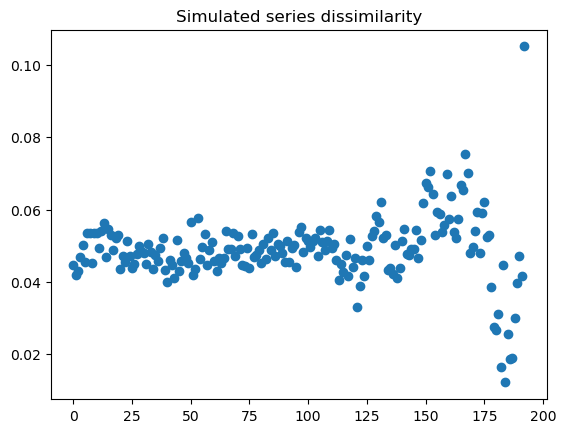

Processing Mouse 4, obtained threshold: 0.0006497686383250855
Trends for Mouse 4 appended to dataframe
first nonzero_idx [  8   6   6   6  19   6   4  14   2   9   3   2   2   9   6   9   2   6
  11   6  17   6   4   5   4   3   5   4   5   7   2   9   9   9   3   5
   6   2   7   6   6   2   7   1  10   4   7   2  10  11   4   5  18  14
   9  10   5   5  19   7 106   2   5   5   4   2   3   1   0   3   3   2
   9   3   2   6   6   8   1  16   9   2   2   2   2   2   8   7   2   2
   6   6   2   6  17  27   7   5   6   1   2   2   4  57   5   5]
Mouse 5: First nonzero species at index [  8   6   6   6  19   6   4  14   2   9   3   2   2   9   6   9   2   6
  11   6  17   6   4   5   4   3   5   4   5   7   2   9   9   9   3   5
   6   2   7   6   6   2   7   1  10   4   7   2  10  11   4   5  18  14
   9  10   5   5  19   7 106   2   5   5   4   2   3   1   0   3   3   2
   9   3   2   6   6   8   1  16   9   2   2   2   2   2   8   7   2   2
   6   6   2   6  17  27   7   5   6   1   

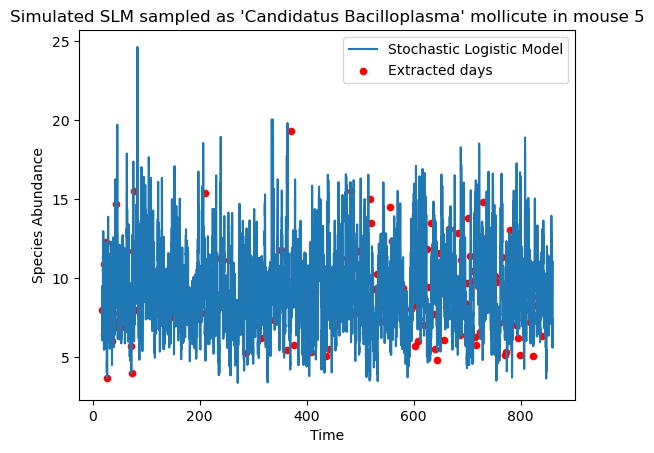

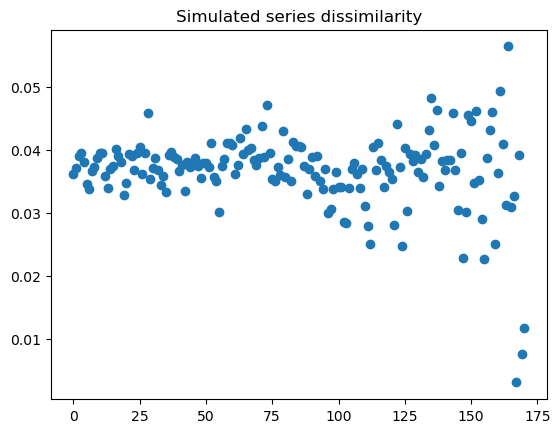

Processing Mouse 5, obtained threshold: 0.0006870466958870312
Trends for Mouse 5 appended to dataframe
first nonzero_idx [ 11   5   5   5   0   7   7   5   1  11   5   1   4  13   9   5  11   5
  11   5   5   5   3   5   5   5   0   7   5   9   5   1  11   5  11   5
   5   5   5   7   5   5  11   5   5   9  10   5   5   5   5  29  13   5
   8   3   5   5  13   5 105   5   5  13   5   5   4   3   2   4   0   5
   5   5   5   5   5  13   0   5  11   1   5   1  10   5  11   4   5   5
   5   5   0   5   8   5   5   5   9  10   5   5  11   5  11   5]
Mouse 6: First nonzero species at index [ 11   5   5   5   0   7   7   5   1  11   5   1   4  13   9   5  11   5
  11   5   5   5   3   5   5   5   0   7   5   9   5   1  11   5  11   5
   5   5   5   7   5   5  11   5   5   9  10   5   5   5   5  29  13   5
   8   3   5   5  13   5 105   5   5  13   5   5   4   3   2   4   0   5
   5   5   5   5   5  13   0   5  11   1   5   1  10   5  11   4   5   5
   5   5   0   5   8   5   5   5   9  10   

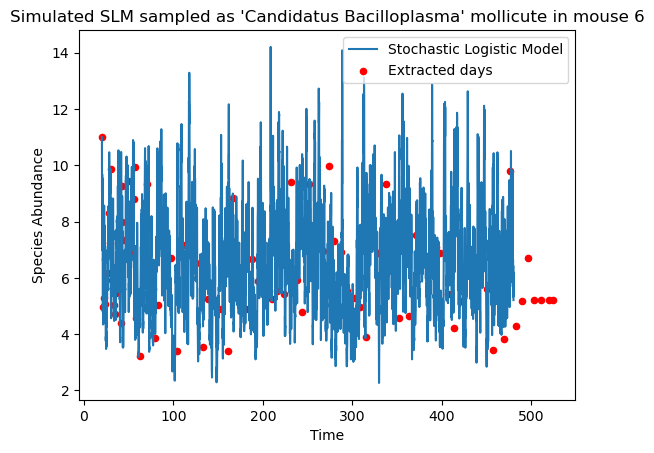

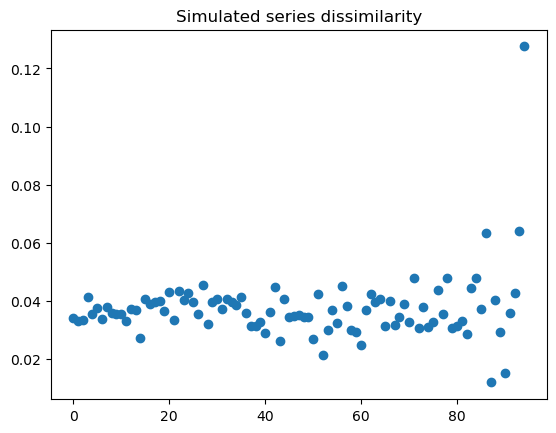

c:\Users\angel\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\angel\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\angel\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Processing Mouse 6, obtained threshold: nan
Trends for Mouse 6 appended to dataframe
first nonzero_idx [ 10   2   8   7   6   7   6   2   4   6   6   2   1  36   7   7   7   7
  10   6   7   7   3   1   3   1   7   6   7   7   7  12  10   7  11   6
   7   1   9   0   7   4  10   6   7   7   7   6   7   7   7   7   9   0
   2   7   7   7   6  11 105   2   7  11   7   5   3   3   3   3   2   3
   9   7   7   2   6   8   2   8  10   7   3   7   7   2   9   8   2   6
   6   7   2   7  10   7   8   7   7   4   7   6   5  31   7   7]
Mouse 7: First nonzero species at index [ 10   2   8   7   6   7   6   2   4   6   6   2   1  36   7   7   7   7
  10   6   7   7   3   1   3   1   7   6   7   7   7  12  10   7  11   6
   7   1   9   0   7   4  10   6   7   7   7   6   7   7   7   7   9   0
   2   7   7   7   6  11 105   2   7  11   7   5   3   3   3   3   2   3
   9   7   7   2   6   8   2   8  10   7   3   7   7   2   9   8   2   6
   6   7   2   7  10   7   8   7   7   4   7   6   5  31   7 

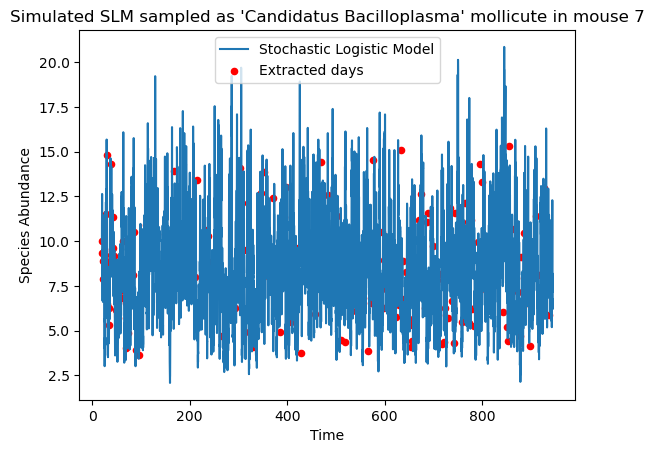

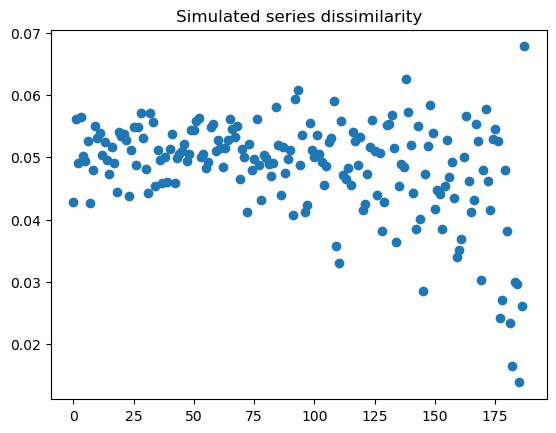

Processing Mouse 7, obtained threshold: 0.0007571882783219341
Trends for Mouse 7 appended to dataframe
first nonzero_idx [ 10   8   1   7   7   7   7   0   0   7   1   2   1   3   7  10   1   1
  11   1   7   1   1   7   6   1   7   7  14   1   7  20  15   7   3   7
   1   5   1   1   7   0   1   1   1   6   7   7   1   7   1  14  10  11
   1   7  10   2   7   7 106   1   7   6   0   1   4   1   2   4   0   4
  10   4   1   1   6   7   1   2  11   0   4   0   7   4  11   7   9   0
   1   7   7   7  10  21   7   7   7   6   4   4   1  39   8   1]
Mouse 8: First nonzero species at index [ 10   8   1   7   7   7   7   0   0   7   1   2   1   3   7  10   1   1
  11   1   7   1   1   7   6   1   7   7  14   1   7  20  15   7   3   7
   1   5   1   1   7   0   1   1   1   6   7   7   1   7   1  14  10  11
   1   7  10   2   7   7 106   1   7   6   0   1   4   1   2   4   0   4
  10   4   1   1   6   7   1   2  11   0   4   0   7   4  11   7   9   0
   1   7   7   7  10  21   7   7   7   6   

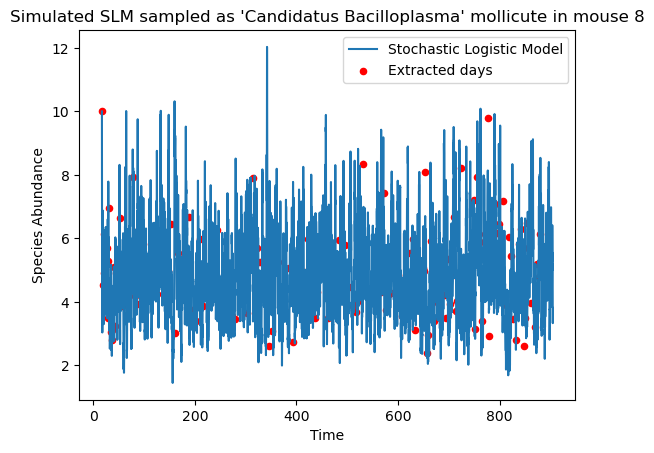

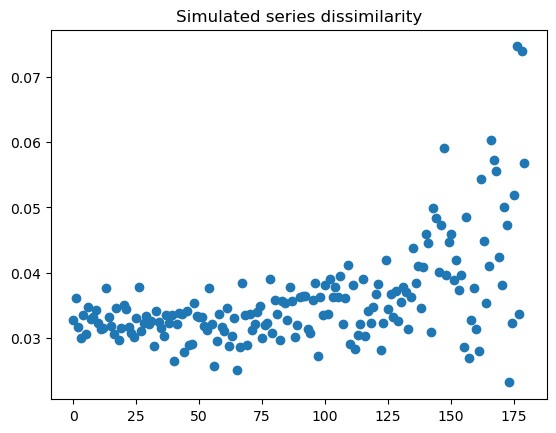

Processing Mouse 8, obtained threshold: 0.0008659863108946798
Trends for Mouse 8 appended to dataframe


In [ ]:
# TRY FOR ALL MICE

# Iterate through all mice
# Extract the DataFrame for the current mouse

#valid_rows = ~(K_df.isna() | sigma_df.isna())
    
mask= np.any(K_df.isna(),axis=1)
K_filtered = K_df[~mask]
sigma_filtered = sigma_df[~mask]

K_filtered=K_filtered.set_index('Unnamed: 0', drop=True)
sigma_filtered=sigma_filtered.set_index('Unnamed: 0', drop=True)

summary_df = []
for mouse_idx, mouse in enumerate(mice_diss):
    
    # Remove the "TREND" column if it exists (to allow re-running the code)
    if 'TREND' in mouse.columns:
        mouse = mouse.drop(columns=['TREND'], inplace=True)  # Avoid inplace modifications

    df = mi.mice_df[mouse_idx] 
    #mouse_species=df['species'] 
    df.index=df['species']
    species_in_both = df.index.intersection(K_filtered.index)
    species_in_both=species_in_both.sort_values() 
    df_filtered = df.loc[species_in_both]

    K_filtered = K_filtered.loc[species_in_both]
    sigma_filtered = sigma_filtered.loc[species_in_both]
 

    # Extract abundance data (excluding metadata columns)
    abundance_data = df_filtered.iloc[:, 4:].to_numpy()

    # Find species with at least one nonzero abundance at any time point
    nonzero_species = np.any(abundance_data > 0, axis=1)  # Fix: Now checks for any nonzero value

    if np.sum(nonzero_species) == 0:  # No species with nonzero values
        print(f"Skipping Mouse {mouse_idx + 1} (no nonzero species)")
        summary_df.append(pd.DataFrame())  # Append empty DataFrame for consistency
        continue  

    # For each species, find the index of the first nonzero time point.
    first_nonzero_idx = np.argmax(abundance_data > 0, axis=1)
    print("first nonzero_idx", first_nonzero_idx)

    # Optionally, handle species that are always zero:
    # first_nonzero_indices = np.where(nonzero_species, first_nonzero_indices, -1)

    # Select the first species that has nonzero abundance
    # first_nonzero_idx = np.argmax(nonzero_species)  # Get index of the first nonzero value for each species
    # start_values = abundance_data[first_nonzero_idx, :]  # Extract time series for that species
    first_nonzero_idx = np.where(nonzero_species, np.argmax(abundance_data > 0, axis = 1), -1)

    # Ensure indices are within the valid range
    first_nonzero_idx = np.clip(first_nonzero_idx, 0, abundance_data.shape[1] - 1)
    
    #start_values = abundance_data[:,first_nonzero_idx:]


    print(f"Mouse {mouse_idx + 1}: First nonzero species at index {first_nonzero_idx}")
    # print(f"Start values: {start_values}")  # Debug print

    # Compute the threshold for the current mouse
    threshold_mouse = threshold(
        #start=start_values,
        start = first_nonzero_idx,
        K_df=K_filtered,  # Pass K values
        sigma_df=sigma_filtered,  # Pass sigma values
        df=df_filtered.iloc[:, 4:],  # Pass only the abundance data
        mouse_num=mouse_idx
    )

    print(f"Processing Mouse {mouse_idx + 1}, obtained threshold: {threshold_mouse}")

    # Store trends for each species
    trend = []

    # Iterate over species in the mouse dataset
    for spec_idx, spec in enumerate(df_filtered.index):  
        time_diss = mouse.loc[spec]

        # Compute the slope using linear regression
        slope_mouse, _, _, _, _ = linregress(np.arange(len(time_diss)), time_diss)

        # Determine the trend based on threshold
        trend.append("incr" if slope_mouse > threshold_mouse else "flat")

    diss_inf_values = sigma_filtered[f"Mouse {mouse_idx + 1}"] / (4 - sigma_filtered[f"Mouse {mouse_idx + 1}"])

    temp_df = pd.DataFrame({
        'TREND': trend,
        'K': K_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'sigma': sigma_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'diss_inf': diss_inf_values.values.flatten()
    }, index=species_in_both)

    # Append to summary DataFrame
    summary_df.append(temp_df)

    # Append trend classification to the DataFrame
    mouse.loc[species_in_both]["TREND"] = trend


    print(f"Trends for Mouse {mouse_idx + 1} appended to dataframe")


In [ ]:
#print(mice_diss[0])
#print(summary_df[0])
normalized_diss_list=[]

for mouse_idx in range(len(mice_diss)):
    selected_species=summary_df[mouse_idx].index
    selected_diss=mice_diss[mouse_idx].loc[selected_species]
    normalized_diss = selected_diss.div(summary_df[mouse_idx]['diss_inf'], axis=0)  # Element-wise division

    normalized_diss_list.append(normalized_diss)  # Store for this mouse

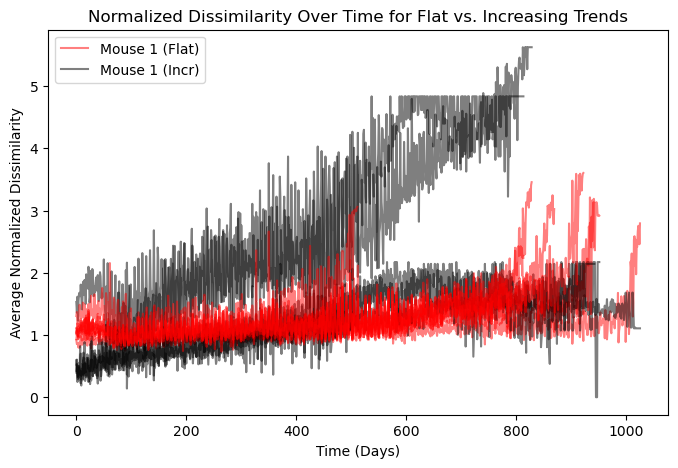

In [ ]:

# Create figure
plt.figure(figsize=(8, 5))

# Iterate through each mouse
for mouse_idx in range(len(mice_diss)):
    if summary_df[mouse_idx].empty or normalized_diss_list[mouse_idx].empty:
        print(f"Skipping Mouse {mouse_idx + 1} (empty data)")
        continue

    # Select species based on TREND
    flat_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'flat'].index
    incr_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index

    # Compute mean dissimilarity across species (rows) for each trend
    mean_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].mean(axis=0)  
    mean_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].mean(axis=0)  

    # X-axis: time points
    time_points = np.arange(len(mean_diss_flat))

    # Plot for the current mouse
    plt.plot(time_points, mean_diss_flat, linestyle='-', color='red', alpha=0.5, label=f'Mouse {mouse_idx+1} (Flat)' if mouse_idx == 0 else "")
    plt.plot(time_points, mean_diss_incr, linestyle='-', color='black', alpha=0.5, label=f'Mouse {mouse_idx+1} (Incr)' if mouse_idx == 0 else "")

# Labels and title
plt.xlabel("Time (Days)")
plt.ylabel("Average Normalized Dissimilarity")
plt.title("Normalized Dissimilarity Over Time for Flat vs. Increasing Trends")
plt.legend()
plt.show()


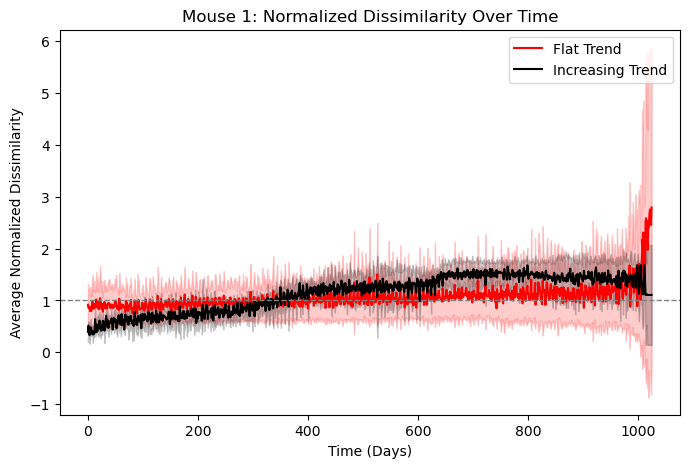

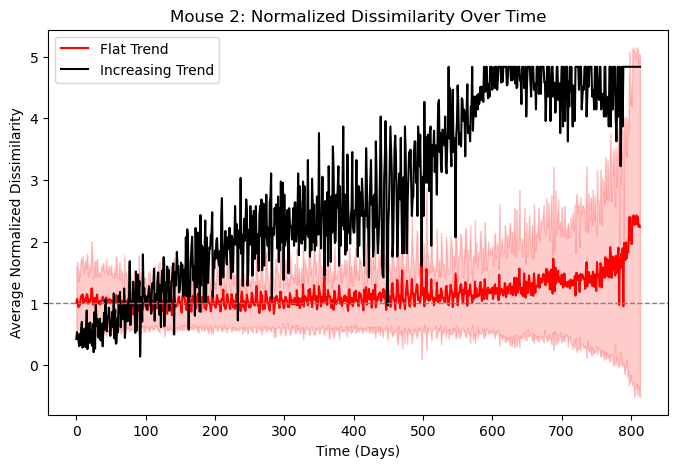

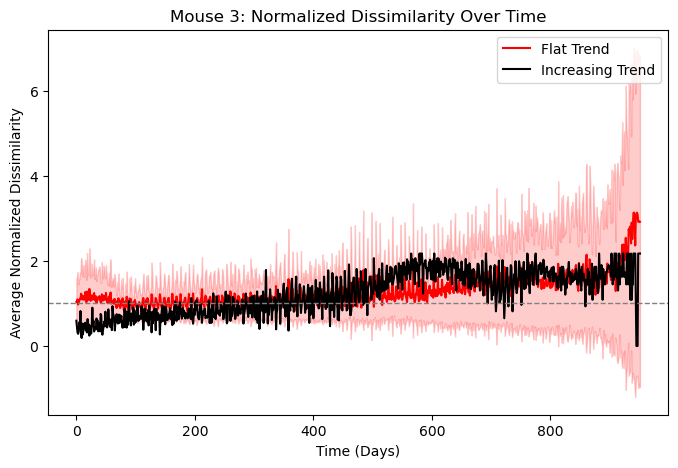

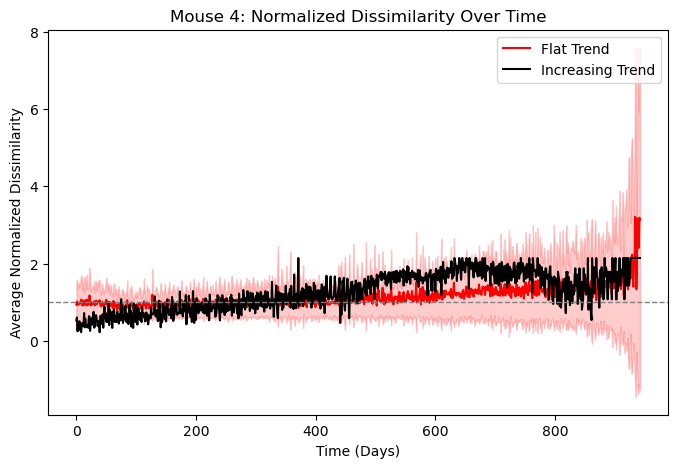

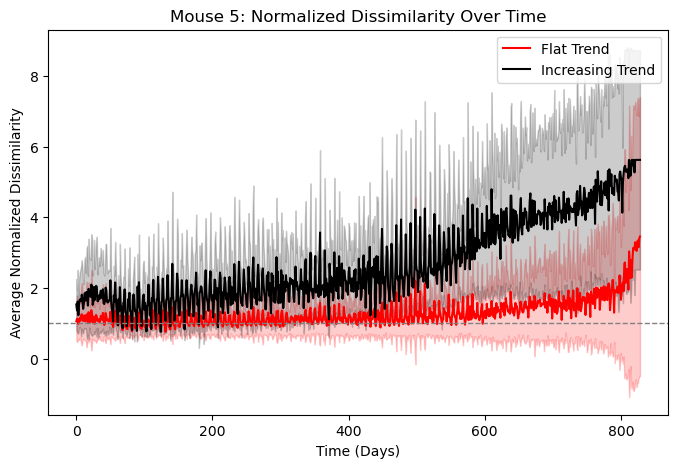

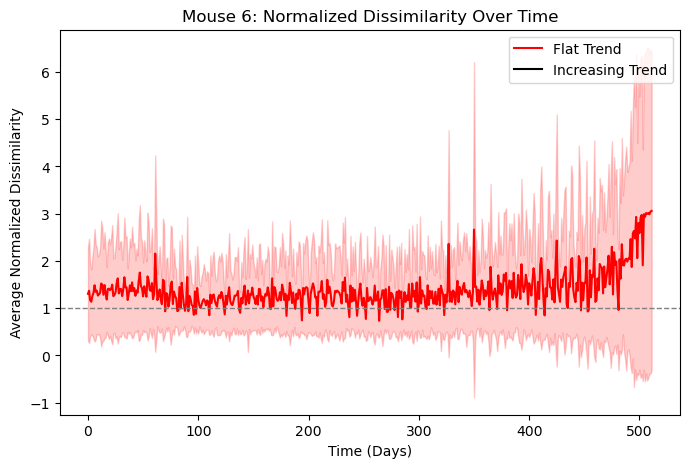

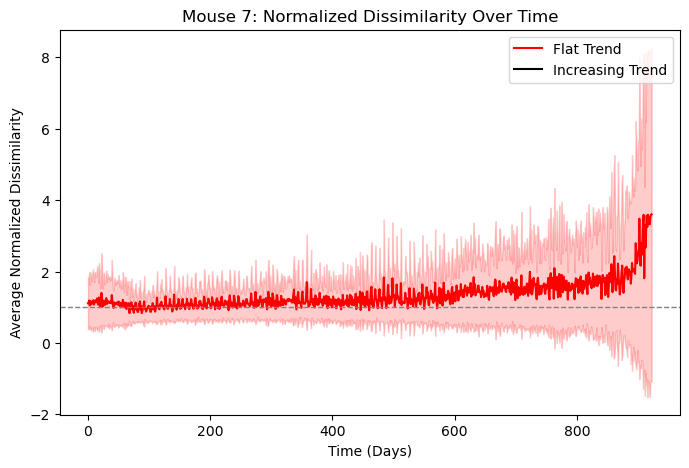

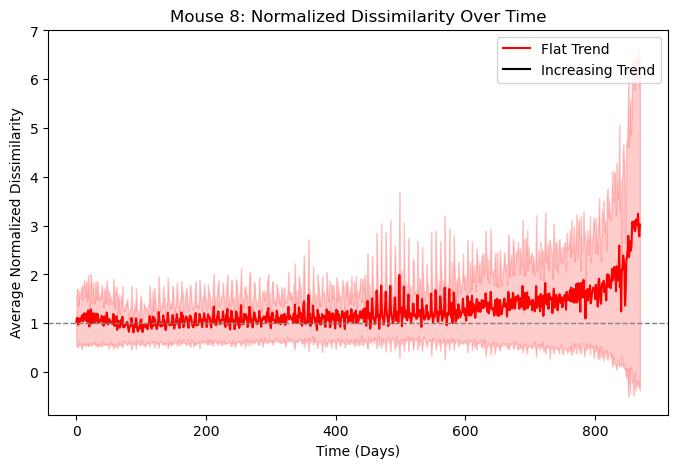

In [ ]:
# Iterate through each mouse
for mouse_idx in range(len(mice_diss)):
    if summary_df[mouse_idx].empty or normalized_diss_list[mouse_idx].empty:
        print(f"Skipping Mouse {mouse_idx + 1} (empty data)")
        continue

    # Select species based on TREND
    flat_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'flat'].index
    incr_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index

    # Compute mean and standard deviation across species for each trend
    mean_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].mean(axis=0)  
    std_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].std(axis=0)

    mean_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].mean(axis=0)  
    std_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].std(axis=0)

    # X-axis: time points
    time_points = np.arange(len(mean_diss_flat))

    # Create a new figure for each mouse
    plt.figure(figsize=(8, 5))

    # Plot mean dissimilarities
    plt.plot(time_points, mean_diss_flat, linestyle='-', color='red', label='Flat Trend')
    plt.plot(time_points, mean_diss_incr, linestyle='-', color='black', label='Increasing Trend')

    # Add shaded region (Mean ± SD)
    plt.fill_between(time_points, mean_diss_flat - std_diss_flat, mean_diss_flat + std_diss_flat, color='red', alpha=0.2)
    plt.fill_between(time_points, mean_diss_incr - std_diss_incr, mean_diss_incr + std_diss_incr, color='black', alpha=0.2)

    # Add a horizontal dashed line at y = 1
    plt.axhline(y=1, color='gray', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Time (Days)")
    plt.ylabel("Average Normalized Dissimilarity")
    plt.title(f"Mouse {mouse_idx + 1}: Normalized Dissimilarity Over Time")
    plt.legend()

    # Show plot for this mouse
    plt.show()


maybe lower the percentile of threshold to include more increasing species

#### TRIAL ON FIRST MOUSE

Perform a taxonomic analysis on species with nonstationary behaviour (common classifications or something else)

## Estimate the parameters of SLM for stationary species

estimate the model parameters $K$ and $\sigma$, from the relations $\left<\lambda\right>=K\left(\frac{2-\sigma}{2}\right)$ and $Var(\lambda)= \left( \frac{\sigma}{2-\sigma} \right) \left<\lambda\right>^2$

- if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution

calculate theoretical expectation value for the dissimilarity at stationarity $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$, compare with the data.


# **NOTE**: 

1. Il estimated K non è esattamente il K del fit, pace? Inoltre, questi valori son senza errori (mi è venuto in mente perché non saprei dire se i due K son compatibili o meno.. ), ma lasciamo stare? (Almeno per ora?)

2. Per ora sto droppando le prime 50 colonne, che non sono i primi 50 tempi

3. Si potrebbe fare che automaticamente capisce dov'è la stazionarietà e droppa le colonne prima (es. ho un tot di valori uguali di fila)

4. I plot dei fit si potrebbero salvare su file

5. Alcuni fit fanno schifo (generalmente sulle specie meno frequenti, cioè le ultime)

6. Maybe we can generalize a function written somewhere else and to be imported for the computation of dissimilarity on both empirical and synthetic data

7. Should we start the simulation from the first non-zero value? DONE

8. PLUS we should sample the synthetic data only in the days corresponding to when data was actually sampled. 